In [2]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
fname1 = "electron_30deg_50wob_NOISE120.mscw.fits"
with fits.open(fname1) as hdul:
   df1 = Table.read(hdul[1]).to_pandas()

fname2 = "protons_30deg_5.0wob_NOISE120.mscw.fits"
with fits.open(fname2) as hdul:
   df2 = Table.read(hdul[1]).to_pandas()

# fname3 = "helium_30deg_5.0wob_NOISE120.mscw.fits"
# with fits.open(fname3) as hdul:
#    df3 = Table.read(hdul[1]).to_pandas()

In [9]:
electron = df1.copy()
gamma = electron.iloc[:,:]  # electron and gamma shower identical after first interaction
proton = df2.copy()
hadron = proton.iloc[:,:]  # proton is hadron
#gamma.info()

In [10]:
gamma['class'] = 1  # postive class
hadron['class'] = 0  # negative class

In [11]:
gamma.shape

(466422, 60)

In [12]:
hadron = hadron.iloc[:466422,:]
hadron.shape

(466422, 60)

In [13]:
particles = pd.concat([gamma, hadron], ignore_index=True)

#particles = gamma.append(hadron)  # combining datasets
particles.shape

(932844, 60)

In [14]:
X = particles[['MSCW', 'MSCL', 'EChi2S', 'EmissionHeight', 
                  'EmissionHeightChi2', 'SizeSecondMax', 
                  'Core']]
col = X
y = particles['class']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
y_train[y_train == 1].shape, y_train[y_train == 0].shape  # class imbalance?

((279911,), (279795,))

In [18]:
import xgboost as xgb
import scipy.stats as sc
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [555]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic')

In [105]:
params = {'n_estimators': [100,200,400,500,800],
              'learning_rate': [0.01, 0.03, 0.1, 0.3, 0.5],
              'subsample': sc.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8],
              'colsample_bytree': sc.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

In [106]:
kfold_5 = KFold(5, shuffle = True, random_state = 42)

In [107]:
bdt=RandomizedSearchCV(xgb_clf,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=kfold_5,verbose=3,random_state=42)

In [108]:
bdt.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=No...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8db1f82dd0>,
                                        'learning_rate': [0.01, 0.03, 0.1, 0.3,
                                                          0.5],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 200, 400, 500,
                                                         800],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8db1f83370>},
                   random_state=42, scoring='roc_auc', verbose=3)

In [581]:
clf = xgb.XGBClassifier(n_estimators = 500, 
                        learning_rate=0.1, 
                        max_depth=5,
                        min_split_loss = 1,
                        objective = 'binary:logistic',
                        random_state = 42)

In [582]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_split_loss=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [5]:
import pickle

In [6]:
model_path = 'BDT_train.sav'

with open(model_path, 'rb') as model_file:
    model = pickle.load(model_file)

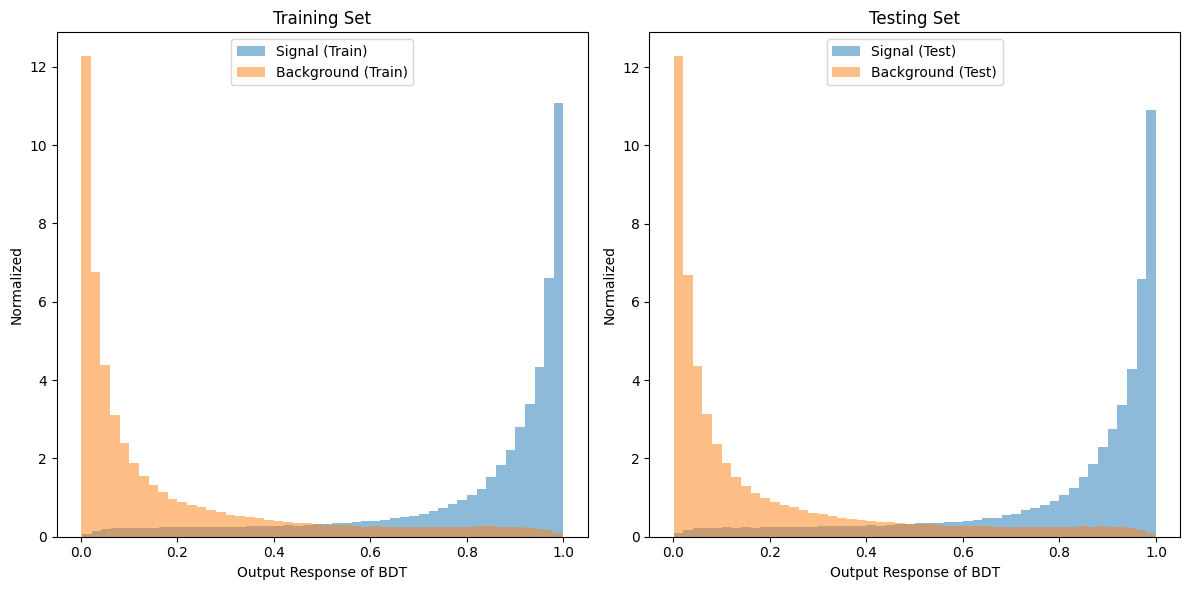

In [34]:
# Checking output responses for overfitting

train_signal_probs = model.predict_proba(X_train)[:, 1]
test_signal_probs = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(12, 6))

# Plot histograms for signal and background in training set
plt.subplot(1, 2, 1)
plt.hist(train_signal_probs[y_train == 1], bins=50, alpha=0.5, label='Signal (Train)', density = True)
plt.hist(train_signal_probs[y_train == 0], bins=50, alpha=0.5, label='Background (Train)', density = True)

plt.xlabel('Output Response of BDT')
plt.ylabel('Normalized')
plt.title('Training Set')
plt.legend(loc = 'upper center')

# Plot histograms for signal and background in testing set
plt.subplot(1, 2, 2)
plt.hist(test_signal_probs[y_test == 1], bins=50, alpha=0.5, label='Signal (Test)', density = True)
plt.hist(test_signal_probs[y_test == 0], bins=50, alpha=0.5, label='Background (Test)', density = True)
plt.xlabel('Output Response of BDT')
plt.ylabel('Normalized')
plt.title('Testing Set')
plt.legend(loc = 'upper center')

plt.tight_layout()
plt.savefig('output_BDT')
plt.show()

In [166]:
print(test_signal_probs)

[0.34709853 0.9397521  0.98958415 ... 0.28317723 0.21133225 0.73301774]


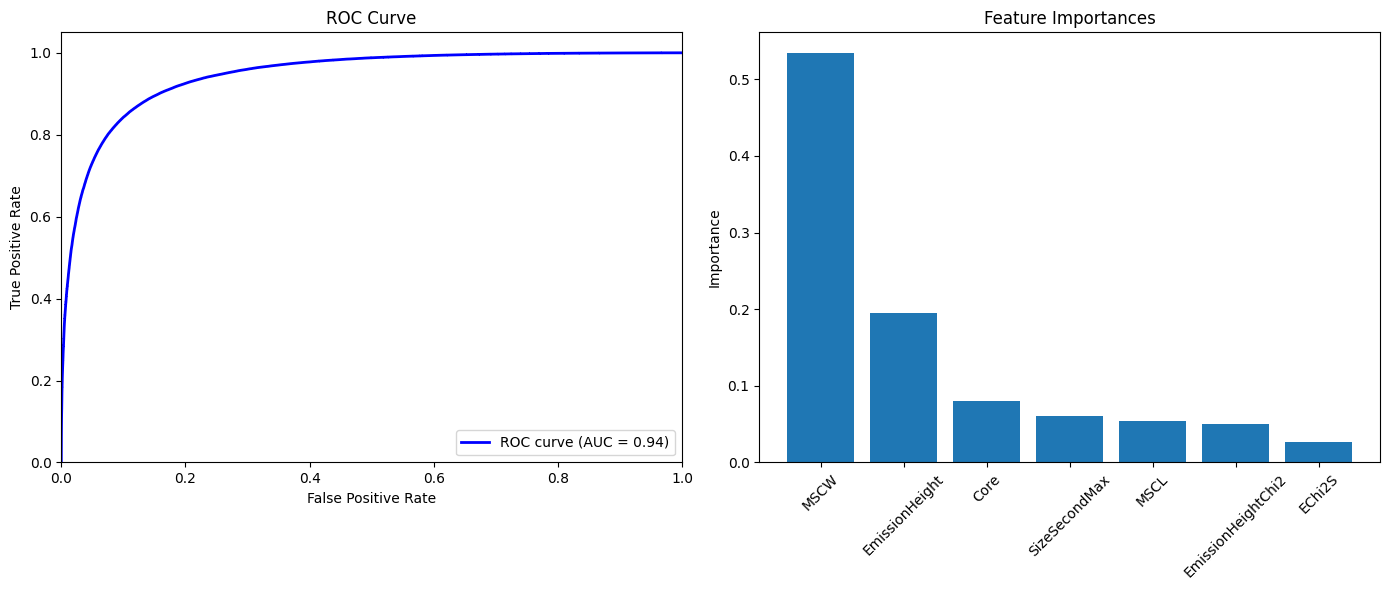

In [36]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_signal_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')


# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': col.columns,
    'Importance': feature_importances
})

# Sort the features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.subplot(1, 2, 2)
# Plot feature importances
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=45)
#plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('BDT_ROC_imp')
plt.show()

In [585]:
y_pred = (test_signal_probs > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate accuracy score
accuracy = np.mean(y_pred == y_test)

print("Area under the ROC curve (AUC): {:.2f}".format(roc_auc))
print("XGBoostClassifier Model Accuracy:", accuracy_score(y_test, y_pred)*100)

Area under the ROC curve (AUC): 0.94
XGBoostClassifier Model Accuracy: 87.36178036008126


In [587]:
import pickle
filename = 'BDT_train.sav'
pickle.dump(clf, open(filename, 'wb'))

In [265]:
test_had = proton.iloc[441984:,:]

In [266]:
test_had_features = test_had[['MSCW', 'MSCL', 'EChi2S', 'EmissionHeight', 
                  'EmissionHeightChi2', 'SizeSecondMax', 
                  'Core']]

In [267]:
test_had_features

,MSCW,MSCL,EChi2S,EmissionHeight,EmissionHeightChi2,SizeSecondMax,Core
441984,0.232024,0.215303,0.390753,10.286369,1.000000e-10,234.068329,56.675360
441985,3.206302,1.812371,0.384007,9.899564,1.000000e-10,569.614929,166.895771
441986,1.376900,0.223845,0.002096,13.410931,2.812639e-01,739.014771,202.859978
441987,12.044406,9.889717,5.258184,18.321714,1.000000e-10,470.084930,84.423128
441988,7.123085,5.972548,0.578641,8.938263,1.193170e+00,3592.738525,125.850283
...,...,...,...,...,...,...,...
1721487,10.233172,12.667301,6.614401,7.634846,1.577725e+00,2252.768066,71.699339
1721488,-0.770668,1.832754,0.051678,9.352324,1.000000e-10,332.968445,131.792101
1721489,2.494160,1.198183,0.012154,9.957376,1.000000e-10,1476.456543,259.954459
1721490,0.072739,2.050305,0.519912,7.193672,3.890851e-01,2895.658447,284.460166


In [268]:
test_had_probs = bdt.predict_proba(test_had_features)[:, 1]

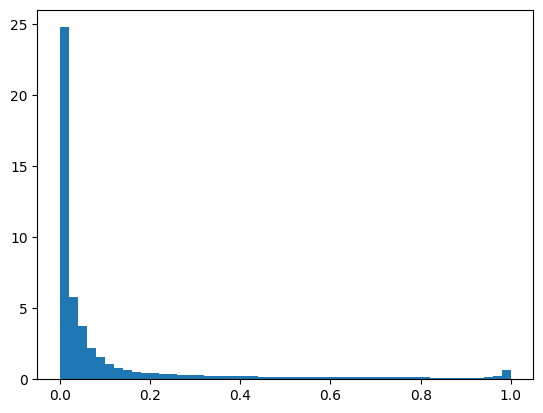

In [269]:
plt.hist(test_had_probs, bins = 50, density=True)
plt.show()  # rejects most hadrons